In [7]:
import cv2
import numpy as np

net = cv2.dnn.readNetFromDarknet("yolov3.cfg","yolov3_1100.weights") #讀取YOLO_V3的模型與權重
layer_names = net.getLayerNames() #讀取hidden-layer
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()] #擷取yolo_82,yolo_94,yolo_106的輸出
classes = [line.strip() for line in open("cfg_mask/obj.names")] 
colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect(frame):
    # forward propogation
    img = cv2.resize(frame, None, fx=0.4, fy=0.4) 
    height, width, channels = img.shape 
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False) 
    #resize to 416*416,(0,0,0)=>mean:用于各通道减去的值，以降低光照的影响,swapRB:交换RB通道，Ture=>默认为False.(cv2.imread读取的是彩图是bgr通道)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # get detection boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.3:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
            cv2.putText(img, label, (x, y -5), font, 1, color, 1)
    return img

Populating the interactive namespace from numpy and matplotlib


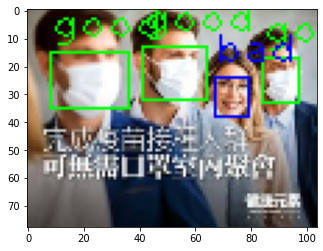

In [8]:
from matplotlib import pyplot as plt
%pylab inline

img = cv2.imread("test.jpg")
im = yolo_detect(img)
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)